# De Texto Completo a Agentic RAG: Busqueda Semantica sobre Don Quijote

---

**Curso:** AI Engineering | **Modulo:** Bases de Datos Vectoriales

---

## Objetivos de Aprendizaje

Al finalizar este notebook, seras capaz de:

1. **Entender** por que existen las bases de datos vectoriales (limites de context stuffing).
2. **Explicar** TF-IDF: formula, intuicion y calculo manual.
3. **Comparar** representaciones sparse (TF-IDF) vs dense (embeddings de OpenAI).
4. **Usar ChromaDB** como base de datos vectorial real con embeddings densos.
5. **Implementar** un pipeline Simple RAG con retrieval semantico.
6. **Construir** un Agentic RAG con LangGraph (grading + re-query loops).
7. **Evaluar** cuantitativamente los 3 enfoques sobre un corpus real (~15K palabras).

---

### Resumen de los 3 Enfoques

| Enfoque | Idea central | Tokens de contexto | Costo aprox. por query |
|---------|-------------|-------------------|----------------------|
| **Context Stuffing** | Pasar TODO el texto al LLM | ~20,000 | ~$0.003 |
| **Simple RAG** | Retrieval + top-3 chunks | ~500 | ~$0.0001 |
| **Agentic RAG** | LangGraph con reasoning loops | ~500-1500 | ~$0.0005 |

> **Nota:** Este notebook usa la API de OpenAI. Se requiere `OPENAI_API_KEY` configurada.

## Reproducibilidad

```bash
cd 02-vector_data_bases
uv sync                    # instala dependencias en .venv/
cp ../.env .env            # o configurar OPENAI_API_KEY directamente
```

Abrir esta notebook en VS Code (el `.vscode/settings.json` apunta al venv correcto) o ejecutar:

```bash
make run-notebook          # ejecucion headless
```

**Dependencias clave:** `chromadb`, `langchain-openai`, `langgraph`, `scikit-learn`, `tiktoken`, `matplotlib`, `seaborn`.

In [1]:
# ==============================================================================
# SETUP: Importaciones y configuracion del entorno
# ==============================================================================

from __future__ import annotations

import re
import time
import urllib.request
from collections import Counter
from typing import TypedDict

import chromadb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tiktoken
from dotenv import find_dotenv, load_dotenv
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langgraph.graph import END, StateGraph
from pydantic import BaseModel, Field
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# --- Configuracion visual ---
sns.set_theme(style="whitegrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["font.size"] = 11

# --- Cargar API key ---
load_dotenv(find_dotenv())

# --- Modelos ---
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)
embeddings_model = OpenAIEmbeddings(model="text-embedding-3-small")
enc = tiktoken.encoding_for_model("gpt-4o-mini")

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# ==============================================================================
# CORPUS: Descargar Don Quijote de Project Gutenberg (capitulos I-VIII)
# ==============================================================================

url = "https://www.gutenberg.org/cache/epub/2000/pg2000.txt"
print(f"Descargando desde {url} ...")

raw = urllib.request.urlopen(url).read().decode("utf-8")
print(f"Texto completo descargado: {len(raw):,} caracteres")

# --- Extraer capitulos I-VIII ---
# Buscamos desde "En un lugar de la Mancha" hasta el inicio del capitulo IX
start_match = re.search(r"En un lugar de la Mancha", raw)
end_match = re.search(r"Cap[ií]tulo\s+(IX|noveno|9)", raw, re.IGNORECASE)

if start_match and end_match:
    texto_quijote = raw[start_match.start() : end_match.start()].strip()
else:
    # Fallback: tomar desde "En un lugar" + ~80K caracteres
    start = raw.find("En un lugar de la Mancha")
    texto_quijote = raw[start : start + 80000].strip()

# --- Limpieza basica ---
texto_quijote = re.sub(r"\r\n", "\n", texto_quijote)
texto_quijote = re.sub(r"\n{3,}", "\n\n", texto_quijote)

# --- Estadisticas ---
palabras = texto_quijote.split()
tokens = enc.encode(texto_quijote)

print("=" * 60)
print("CORPUS: Don Quijote, Capitulos I-VIII")
print("=" * 60)
print(f"Palabras:       {len(palabras):,}")
print(f"Tokens:         {len(tokens):,}")
print(f"Caracteres:     {len(texto_quijote):,}")
print("=" * 60)
print("\nPreview (primeros 300 chars):")
print(f"  {texto_quijote[:300]}...")

Descargando desde https://www.gutenberg.org/cache/epub/2000/pg2000.txt ...


Texto completo descargado: 2,168,076 caracteres
CORPUS: Don Quijote, Capitulos I-VIII
Palabras:       18,059
Tokens:         27,697
Caracteres:     98,919

Preview (primeros 300 chars):
  En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
rocín flaco y galgo corredor. Una olla de algo más vaca que carnero,
salpicón las más noches, duelos y quebrantos los sábados, lantejas los
viernes, alg...


---

## Seccion 1: El Problema -- Context Stuffing

### Por que necesitamos bases de datos vectoriales?

Cuando un texto es largo, pasar TODO el contenido como contexto al LLM tiene problemas serios:

1. **Costo en tokens**: Cada query cuesta O(|T|) tokens de input. Con gpt-4o-mini a $0.15/1M input tokens, un texto de 20K tokens cuesta ~$0.003 por query. Parece poco, pero a 1000 queries/dia = **$3/dia solo en contexto**.

2. **Latencia**: Mas tokens = mas tiempo de procesamiento. La latencia crece linealmente.

3. **"Lost in the middle"** (Liu et al., 2023): Los LLMs pierden informacion que esta en la mitad del contexto largo. Solo atienden bien al principio y al final.

```
┌─────────────────────────────────────────────────────┐
│           CONTEXT STUFFING: ~20K tokens             │
│                                                     │
│  Query ──► [TODO el texto de 8 capitulos] ──► LLM   │
│                                                     │
│  Problema: caro, lento, pierde info del medio       │
└─────────────────────────────────────────────────────┘
```

**Pregunta clave**: Y si pudieramos encontrar SOLO los parrafos relevantes?

In [3]:
# ==============================================================================
# CONTEXT STUFFING: Pasar TODO el texto como contexto al LLM
# ==============================================================================


def context_stuffing_answer(query: str, context: str) -> dict:
    """Pasa todo el texto como contexto al LLM y mide tokens/costo/latencia."""
    t0 = time.perf_counter()

    prompt = (
        f"Contexto completo:\n{context}\n\n"
        f"Pregunta: {query}\n\n"
        "Responde de forma concisa basandote unicamente en el contexto."
    )
    response = llm.invoke(prompt)
    latency_s = time.perf_counter() - t0

    # Conteo real de tokens con tiktoken
    input_tokens = len(enc.encode(prompt))
    output_tokens = len(enc.encode(response.content))

    # Costos gpt-4o-mini: $0.15/1M input, $0.60/1M output
    cost_input = input_tokens * 0.15 / 1_000_000
    cost_output = output_tokens * 0.60 / 1_000_000
    cost_total = cost_input + cost_output

    return {
        "query": query,
        "answer": response.content,
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "cost_usd": cost_total,
        "latency_s": latency_s,
    }


# --- Test ---
test_query = "Que piensa Cervantes sobre los libros de caballeria?"
cs_result = context_stuffing_answer(test_query, texto_quijote)

print("=" * 60)
print("CONTEXT STUFFING")
print("=" * 60)
print(f"Query:          {cs_result['query']}")
print(f"Answer:         {cs_result['answer'][:200]}...")
print(f"Input tokens:   {cs_result['input_tokens']:,}")
print(f"Output tokens:  {cs_result['output_tokens']:,}")
print(f"Costo:          ${cs_result['cost_usd']:.6f}")
print(f"Latencia:       {cs_result['latency_s']:.1f}s")
print("=" * 60)

# Proyeccion
daily_cost = cs_result["cost_usd"] * 1000
print("\nProyeccion: Si haces 1,000 queries/dia:")
print(f"  Costo diario:  ${daily_cost:.2f}")
print(f"  Costo mensual: ${daily_cost * 30:.2f}")

CONTEXT STUFFING
Query:          Que piensa Cervantes sobre los libros de caballeria?
Answer:         Cervantes, a través de la figura de don Quijote, critica los libros de caballería, considerándolos responsables de la locura de su protagonista. Muestra cómo estos libros distorsionan la realidad y ll...
Input tokens:   27,730
Output tokens:  150
Costo:          $0.004249
Latencia:       14.2s

Proyeccion: Si haces 1,000 queries/dia:
  Costo diario:  $4.25
  Costo mensual: $127.48


---

**Resultado**: Funciona, pero gasta ~20K tokens por query solo en contexto. Necesitamos una forma de **convertir texto en numeros** para poder **buscar** los fragmentos relevantes en vez de pasar todo.

Eso es exactamente lo que hace **TF-IDF** (y despues, los **embeddings densos**).

---

## Seccion 2: TF-IDF -- De Texto a Numeros

### Intuicion

Una palabra es **importante en un documento** si:
- Es **frecuente** en ese documento (Term Frequency)
- Es **rara** en el resto del corpus (Inverse Document Frequency)

### Formula

$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$

Donde:

$$
\text{TF}(t, d) = \frac{\text{veces que } t \text{ aparece en } d}{\text{total de palabras en } d}
$$

$$
\text{IDF}(t) = \log\left(\frac{N}{\text{docs que contienen } t}\right)
$$

### Ejemplo Conceptual

| Palabra | TF (en cap. 1) | IDF (8 capitulos) | TF-IDF |
|---------|----------------|-------------------|--------|
| "de" | Alta (muy frecuente) | Bajo (aparece en todos) | **Bajo** |
| "Quijote" | Media | Medio-alto | **Medio-alto** |
| "Rocinante" | Baja (solo algunos caps) | Alto (raro en el corpus) | **Alto si aparece** |

> **Clave**: TF-IDF automaticamente reduce el peso de las "stop words" (de, el, la, los) y amplifica las palabras discriminativas.

In [4]:
# ==============================================================================
# TF-IDF: Calculo manual con 3 oraciones cortas
# ==============================================================================

# Mini corpus para demostrar TF-IDF
mini_corpus = [
    "el hidalgo tenia un rocin flaco",
    "el rocin del hidalgo era viejo",
    "sancho montaba un burro gris",
]

print("=" * 60)
print("CALCULO MANUAL DE TF-IDF")
print("=" * 60)

# --- TF manual ---
print("\n1. Term Frequency (TF) por documento:")
print("-" * 60)
for i, doc in enumerate(mini_corpus):
    words = doc.split()
    counts = Counter(words)
    tf = {w: c / len(words) for w, c in counts.items()}
    top3 = sorted(tf.items(), key=lambda x: -x[1])[:5]
    print(f"  Doc {i}: {doc}")
    print(f"         TF top-5: {dict(top3)}")

# --- Sklearn TfidfVectorizer para comparar ---
print("\n2. Matriz TF-IDF completa (sklearn):")
print("-" * 60)

vectorizer = TfidfVectorizer()
tfidf_matrix = vectorizer.fit_transform(mini_corpus)
feature_names = vectorizer.get_feature_names_out()

df_tfidf = pd.DataFrame(
    tfidf_matrix.toarray(),
    columns=feature_names,
    index=[f"Doc {i}" for i in range(len(mini_corpus))],
)

# Mostrar la matriz completa
print(df_tfidf.round(3).to_string())

# --- Observacion ---
print("\n3. Observacion clave:")
print("-" * 60)
print("  'el' tiene score BAJO (aparece en doc 0 y doc 1 -> IDF bajo)")
print("  'burro' tiene score ALTO (solo aparece en doc 2 -> IDF alto)")
print("  'hidalgo' tiene score MEDIO (aparece en 2 de 3 docs)")

# Mostrar scores especificos
for word in ["el", "burro", "hidalgo", "rocin"]:
    if word in feature_names:
        idx = list(feature_names).index(word)
        scores = tfidf_matrix.toarray()[:, idx]
        max_score = max(scores)
        print(f"  '{word}': max TF-IDF = {max_score:.3f}")

CALCULO MANUAL DE TF-IDF

1. Term Frequency (TF) por documento:
------------------------------------------------------------
  Doc 0: el hidalgo tenia un rocin flaco
         TF top-5: {'el': 0.16666666666666666, 'hidalgo': 0.16666666666666666, 'tenia': 0.16666666666666666, 'un': 0.16666666666666666, 'rocin': 0.16666666666666666}
  Doc 1: el rocin del hidalgo era viejo
         TF top-5: {'el': 0.16666666666666666, 'rocin': 0.16666666666666666, 'del': 0.16666666666666666, 'hidalgo': 0.16666666666666666, 'era': 0.16666666666666666}
  Doc 2: sancho montaba un burro gris
         TF top-5: {'sancho': 0.2, 'montaba': 0.2, 'un': 0.2, 'burro': 0.2, 'gris': 0.2}

2. Matriz TF-IDF completa (sklearn):
------------------------------------------------------------
       burro   del     el   era  flaco   gris  hidalgo  montaba  rocin  sancho  tenia     un  viejo
Doc 0  0.000  0.00  0.366  0.00  0.481  0.000    0.366    0.000  0.366   0.000  0.481  0.366   0.00
Doc 1  0.000  0.46  0.349  0.46  0.00

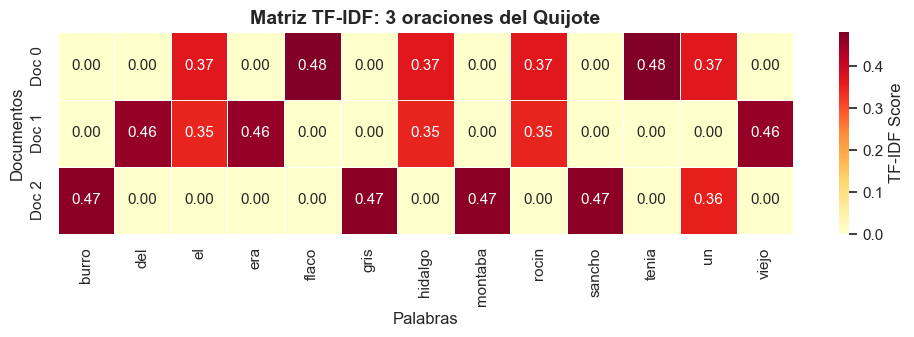

Las celdas mas oscuras indican palabras mas discriminativas.
'el' es claro (poco informativo), 'burro' y 'gris' son oscuros (muy informativos).


In [5]:
# ==============================================================================
# VISUALIZACION: Heatmap de la matriz TF-IDF del ejemplo mini
# ==============================================================================

fig, ax = plt.subplots(figsize=(10, 3.5))

sns.heatmap(
    df_tfidf,
    annot=True,
    fmt=".2f",
    cmap="YlOrRd",
    ax=ax,
    linewidths=0.5,
    cbar_kws={"label": "TF-IDF Score"},
)

ax.set_title("Matriz TF-IDF: 3 oraciones del Quijote", fontsize=14, fontweight="bold")
ax.set_xlabel("Palabras")
ax.set_ylabel("Documentos")

plt.tight_layout()
plt.show()

print("Las celdas mas oscuras indican palabras mas discriminativas.")
print("'el' es claro (poco informativo), 'burro' y 'gris' son oscuros (muy informativos).")

---

### Limitacion de TF-IDF: No Entiende Semantica

TF-IDF es una representacion **sparse** (la mayoria de valores son 0). Tiene un problema fundamental:

```
"rocin flaco"  vs  "caballo delgado"
     │                    │
     ▼                    ▼
 TF-IDF score = 0.0  (NO comparten palabras!)
```

Aunque significan lo mismo, TF-IDF les asigna **similitud cero** porque no comparten ningun termino.

### Sparse vs Dense: Tabla Comparativa

| Dimension | TF-IDF (Sparse) | Embeddings (Dense) |
|-----------|-----------------|-------------------|
| Representacion | Vector de |V| dims, mayoria 0 | Vector de ~1536 dims, todos != 0 |
| Captura semantica | No | Si |
| "rocin" ≈ "caballo" | No (score = 0) | Si (vectores cercanos) |
| Velocidad | Muy rapida (solo multiplicar) | Requiere modelo de embeddings |
| Costo | Gratis (local) | API call (OpenAI) |
| Mejor para | Busqueda por keywords exactas | Busqueda por significado |

**Siguiente paso**: Necesitamos embeddings **densos** que capturen el significado. Para eso usamos un modelo de embeddings (OpenAI) y una base de datos vectorial (ChromaDB).

In [6]:
# ==============================================================================
# CHUNKING: Dividir el texto en fragmentos con RecursiveCharacterTextSplitter
# ==============================================================================

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,
    chunk_overlap=50,
    length_function=len,
    separators=["\n\n", "\n", ". ", " ", ""],
)

chunks = text_splitter.split_text(texto_quijote)

# --- Estadisticas ---
chunk_tokens = [len(enc.encode(c)) for c in chunks]

print("=" * 60)
print("CHUNKING DEL TEXTO")
print("=" * 60)
print(f"Chunks generados:      {len(chunks)}")
print(f"Tokens promedio/chunk: {np.mean(chunk_tokens):.0f}")
print(f"Tokens min/max:        {min(chunk_tokens)} / {max(chunk_tokens)}")
print(f"Tokens totales:        {sum(chunk_tokens):,}")
print("=" * 60)

# Ejemplo de 2 chunks
for i in [0, len(chunks) // 2]:
    print(f"\nChunk {i} ({chunk_tokens[i]} tokens):")
    print(f"  {chunks[i][:150]}...")

CHUNKING DEL TEXTO
Chunks generados:      282
Tokens promedio/chunk: 98
Tokens min/max:        12 / 152
Tokens totales:        27,681

Chunk 0 (121 tokens):
  En un lugar de la Mancha, de cuyo nombre no quiero acordarme, no ha mucho
tiempo que vivía un hidalgo de los de lanza en astillero, adarga antigua,
ro...

Chunk 141 (59 tokens):
  él que le venía de molde para el paso en que se hallaba; y así, con
muestras de grande sentimiento, se comenzó a volcar por la tierra y a decir
con de...


TF-IDF SOBRE CHUNKS REALES
Sparse matrix shape:  (282, 5000)
Sparsity:             98.6%
Non-zero elements:    19,140 / 1,410,000



Test: 'libros de caballeria'
  Chunk 3 (score=0.281): Es, pues, de saber que este sobredicho hidalgo, los ratos que estaba
ocioso, que...
  Chunk 196 (score=0.264): — Este libro es —dijo el barbero, abriendo otro— Los diez libros de Fortuna
de A...
  Chunk 192 (score=0.179): — Así será —respondió el barbero—; pero, ¿qué haremos destos pequeños libros
que...


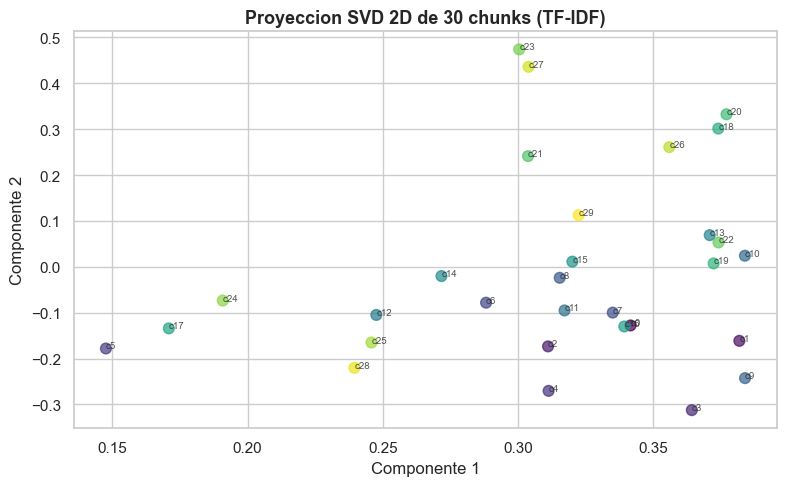

In [7]:
# ==============================================================================
# TF-IDF: Busqueda sparse sobre los chunks reales del Quijote
# ==============================================================================

from sklearn.decomposition import TruncatedSVD

tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=5000)
tfidf_matrix_real = tfidf_vectorizer.fit_transform(chunks)

print("=" * 60)
print("TF-IDF SOBRE CHUNKS REALES")
print("=" * 60)
print(f"Sparse matrix shape:  {tfidf_matrix_real.shape}")
total_elements = tfidf_matrix_real.shape[0] * tfidf_matrix_real.shape[1]
nonzero = tfidf_matrix_real.nnz
sparsity = (1 - nonzero / total_elements) * 100
print(f"Sparsity:             {sparsity:.1f}%")
print(f"Non-zero elements:    {nonzero:,} / {total_elements:,}")
print("=" * 60)


def tfidf_search(query: str, k: int = 3) -> list[dict]:
    """Busqueda TF-IDF sobre los chunks del Quijote."""
    q_vec = tfidf_vectorizer.transform([query])
    sims = cosine_similarity(q_vec, tfidf_matrix_real)[0]
    top_idx = np.argsort(sims)[::-1][:k]
    return [
        {"chunk_id": int(i), "score": float(sims[i]), "text": chunks[int(i)]}
        for i in top_idx
    ]


# --- Test ---
test_results = tfidf_search("libros de caballeria")
print("\nTest: 'libros de caballeria'")
for r in test_results:
    print(f"  Chunk {r['chunk_id']} (score={r['score']:.3f}): {r['text'][:80]}...")

# --- SVD 2D projection ---
n_display = min(30, len(chunks))
svd = TruncatedSVD(n_components=2, random_state=42)
coords = svd.fit_transform(tfidf_matrix_real[:n_display])

fig, ax = plt.subplots(figsize=(8, 5))
ax.scatter(
    coords[:, 0], coords[:, 1], s=60, alpha=0.7,
    c=range(n_display), cmap="viridis",
)
for i, (x, y) in enumerate(coords):
    ax.annotate(f"c{i}", (x, y), fontsize=7, alpha=0.8)
ax.set_title(
    f"Proyeccion SVD 2D de {n_display} chunks (TF-IDF)",
    fontsize=13, fontweight="bold",
)
ax.set_xlabel("Componente 1")
ax.set_ylabel("Componente 2")
plt.tight_layout()
plt.show()

---

## Seccion 3: ChromaDB -- Base de Datos Vectorial Real

### Que es ChromaDB?

ChromaDB es una base de datos vectorial open-source que almacena **documentos + embeddings + metadata** y permite busqueda por similitud semantica.

### Que almacena cada documento?

```
┌─────────────────────────────────────────────────────┐
│              ChromaDB Collection                     │
│                                                      │
│  ┌────────────────────────────────────────────────┐  │
│  │  ID:        "chunk_042"                        │  │
│  │  Document:  "En un lugar de la Mancha..."      │  │
│  │  Embedding: [0.12, -0.45, 0.78, ..., 0.33]    │  │
│  │  Metadata:  {capitulo: 1, posicion: 0}         │  │
│  └────────────────────────────────────────────────┘  │
│                                                      │
│  Indice HNSW para busqueda rapida (O(log n))         │
└─────────────────────────────────────────────────────┘
```

### Flujo: Agregar y Buscar

```
AGREGAR:                          BUSCAR:

documents ──► embed ──► add()     query ──► embed ──► collection.query()
                  │                              │
                  ▼                              ▼
            ┌──────────┐                 Similitud coseno
            │ ChromaDB │                 contra todos los
            │  (HNSW)  │                 vectores indexados
            └──────────┘                        │
                                                ▼
                                          Top-k documentos
```

In [8]:
# ==============================================================================
# CHROMADB: Crear coleccion + agregar chunks con embeddings de OpenAI
# ==============================================================================

# Cliente in-memory (para desarrollo/prototipado)
chroma_client = chromadb.Client()

# Crear coleccion
collection = chroma_client.get_or_create_collection(
    name="quijote_caps_1_8",
    metadata={"hnsw:space": "cosine"},
)

# --- Generar embeddings con OpenAI ---
print("Generando embeddings para todos los chunks con OpenAI...")
t0 = time.perf_counter()

# Batch embedding (max ~2000 por batch para OpenAI)
batch_size = 500
all_embeddings = []
for i in range(0, len(chunks), batch_size):
    batch = chunks[i : i + batch_size]
    batch_embs = embeddings_model.embed_documents(batch)
    all_embeddings.extend(batch_embs)
    print(f"  Batch {i // batch_size + 1}: {len(batch)} chunks embebidos")

embedding_time = time.perf_counter() - t0

# --- Agregar a ChromaDB ---
ids = [f"chunk_{i:04d}" for i in range(len(chunks))]
metadatas = [{"chunk_id": i, "n_tokens": len(enc.encode(c))} for i, c in enumerate(chunks)]

collection.add(
    ids=ids,
    documents=chunks,
    embeddings=all_embeddings,
    metadatas=metadatas,
)

print("=" * 60)
print("CHROMADB: COLECCION CREADA")
print("=" * 60)
print(f"Coleccion:       {collection.name}")
print(f"Documentos:      {collection.count()}")
print(f"Embedding dims:  {len(all_embeddings[0])}")
print(f"Tiempo:          {embedding_time:.1f}s")
print("=" * 60)

Generando embeddings para todos los chunks con OpenAI...


  Batch 1: 282 chunks embebidos
CHROMADB: COLECCION CREADA
Coleccion:       quijote_caps_1_8
Documentos:      282
Embedding dims:  1536
Tiempo:          2.0s


In [9]:
# ==============================================================================
# COMPARACION: TF-IDF vs ChromaDB para las mismas queries
# ==============================================================================


def chroma_search(query: str, k: int = 3) -> list[dict]:
    """Busqueda semantica en ChromaDB con embeddings de OpenAI."""
    q_embedding = embeddings_model.embed_query(query)
    results = collection.query(
        query_embeddings=[q_embedding],
        n_results=k,
        include=["documents", "distances", "metadatas"],
    )
    return [
        {
            "chunk_id": results["metadatas"][0][i]["chunk_id"],
            "score": 1 - results["distances"][0][i],  # cosine similarity
            "text": results["documents"][0][i],
        }
        for i in range(len(results["documents"][0]))
    ]


# --- Queries de prueba ---
test_queries = [
    "Que piensa Cervantes sobre los libros de caballeria?",
    "Describe al caballo delgado del protagonista",  # semantica: rocin flaco
    "Que papel juega la locura en la historia?",
]

print("=" * 60)
print("COMPARACION: TF-IDF vs ChromaDB (Top-1)")
print("=" * 60)

for q in test_queries:
    tfidf_top = tfidf_search(q, k=1)[0]
    chroma_top = chroma_search(q, k=1)[0]

    print(f"\nQuery: '{q}'")
    print(f"  TF-IDF  (chunk {tfidf_top['chunk_id']}, score={tfidf_top['score']:.3f}):")
    print(f"    {tfidf_top['text'][:100]}...")
    print(f"  ChromaDB (chunk {chroma_top['chunk_id']}, score={chroma_top['score']:.3f}):")
    print(f"    {chroma_top['text'][:100]}...")

print("\n" + "=" * 60)
print("Observa: Para 'caballo delgado', ChromaDB encuentra chunks")
print("sobre 'rocin flaco' (sinonimo semantico). TF-IDF no puede.")
print("=" * 60)

COMPARACION: TF-IDF vs ChromaDB (Top-1)



Query: 'Que piensa Cervantes sobre los libros de caballeria?'
  TF-IDF  (chunk 3, score=0.189):
    Es, pues, de saber que este sobredicho hidalgo, los ratos que estaba
ocioso, que eran los más del añ...
  ChromaDB (chunk 188, score=0.592):
    Y, sin querer cansarse más en leer libros de caballerías, mandó al ama que
tomase todos los grandes ...



Query: 'Describe al caballo delgado del protagonista'
  TF-IDF  (chunk 225, score=0.160):
    para ello, quitándole el caballo al primer descortés caballero que topase.
Proveyóse de camisas y de...
  ChromaDB (chunk 104, score=0.499):
    Y, volviendo las riendas, encaminó a Rocinante hacia donde le pareció que
las voces salían. Y, a poc...



Query: 'Que papel juega la locura en la historia?'
  TF-IDF  (chunk 79, score=0.262):
    Contó el ventero a todos cuantos estaban en la venta la locura de su
huésped, la vela de las armas y...
  ChromaDB (chunk 79, score=0.454):
    Contó el ventero a todos cuantos estaban en la venta la locura de su
huésped, la vela de las armas y...

Observa: Para 'caballo delgado', ChromaDB encuentra chunks
sobre 'rocin flaco' (sinonimo semantico). TF-IDF no puede.


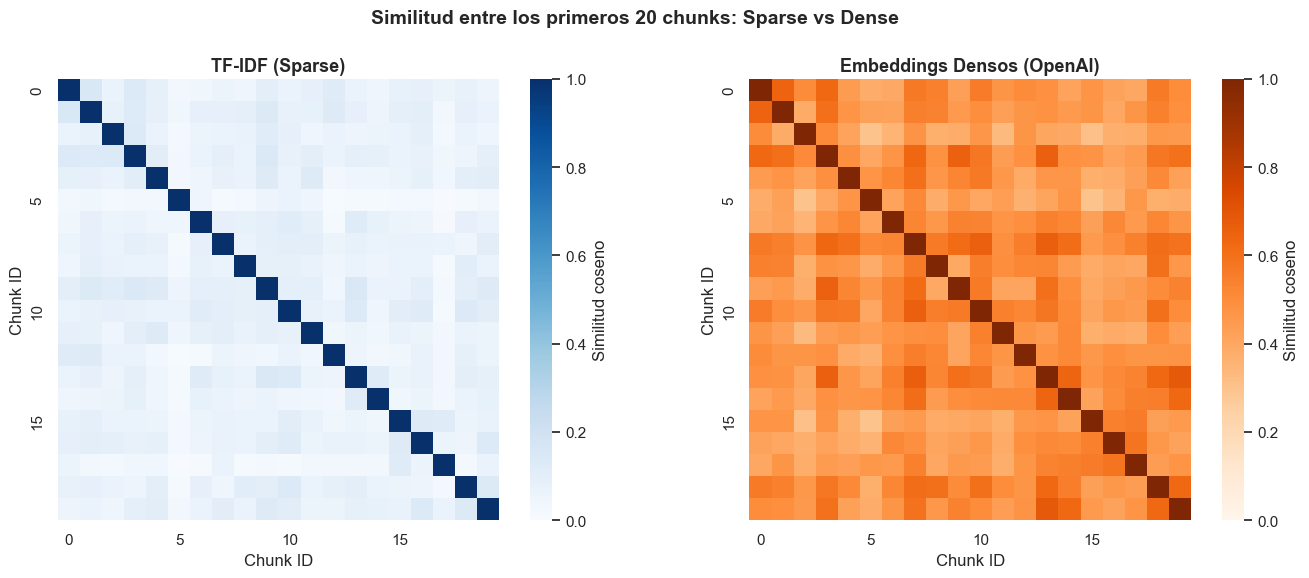

Los embeddings densos capturan similitud semantica entre chunks
que no comparten palabras exactas (bloques mas calidos fuera de la diagonal).


In [10]:
# ==============================================================================
# VISUALIZACION DUAL: TF-IDF similarity vs Dense embedding similarity
# ==============================================================================

n_display = 20  # Primeros 20 chunks

# --- TF-IDF cosine similarity ---
tfidf_sim = cosine_similarity(tfidf_matrix_real[:n_display]).astype(float)

# --- Dense embedding similarity ---
dense_embs = np.array(all_embeddings[:n_display])
dense_sim = cosine_similarity(dense_embs).astype(float)

# --- Plot dual ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5.5))

sns.heatmap(
    tfidf_sim, ax=axes[0], cmap="Blues", vmin=0, vmax=1,
    xticklabels=5, yticklabels=5, square=True,
    cbar_kws={"label": "Similitud coseno"},
)
axes[0].set_title("TF-IDF (Sparse)", fontsize=13, fontweight="bold")
axes[0].set_xlabel("Chunk ID")
axes[0].set_ylabel("Chunk ID")

sns.heatmap(
    dense_sim, ax=axes[1], cmap="Oranges", vmin=0, vmax=1,
    xticklabels=5, yticklabels=5, square=True,
    cbar_kws={"label": "Similitud coseno"},
)
axes[1].set_title("Embeddings Densos (OpenAI)", fontsize=13, fontweight="bold")
axes[1].set_xlabel("Chunk ID")
axes[1].set_ylabel("Chunk ID")

fig.suptitle(
    f"Similitud entre los primeros {n_display} chunks: Sparse vs Dense",
    fontsize=14, fontweight="bold", y=1.02,
)
plt.tight_layout()
plt.show()

print("Los embeddings densos capturan similitud semantica entre chunks")
print("que no comparten palabras exactas (bloques mas calidos fuera de la diagonal).")

---

## Seccion 4: Simple RAG -- Retrieval + Generation

### La idea central

En vez de pasar TODO el texto (~20K tokens), solo pasamos los chunks mas relevantes (~500 tokens):

```
CONTEXT STUFFING:
  Query ──► [TODO el texto: ~20,000 tokens] ──► LLM ──► Respuesta

SIMPLE RAG:
  Query ──► Embed ──► ChromaDB ──► Top-3 chunks (~500 tokens) ──► LLM ──► Respuesta

                          ~40x menos tokens!
```

### Ventajas

- **~40x reduccion** en tokens de contexto
- **Menor costo** por query
- **Menor latencia** (menos tokens para procesar)
- **Foco**: El LLM solo ve informacion relevante, evitando "lost in the middle"

In [11]:
# ==============================================================================
# SIMPLE RAG: Retrieval desde ChromaDB + generacion con LLM
# ==============================================================================


def rag_simple(query: str, k: int = 3) -> dict:
    """Simple RAG: busqueda en ChromaDB + generacion con LLM."""
    t0 = time.perf_counter()

    # Retrieval
    retrieved = chroma_search(query, k=k)
    context = "\n\n".join(
        f"[Chunk {r['chunk_id']} | sim={r['score']:.3f}] {r['text']}"
        for r in retrieved
    )

    # Generation
    prompt = (
        f"Contexto recuperado:\n{context}\n\n"
        f"Pregunta: {query}\n\n"
        "Responde de forma concisa basandote unicamente en el contexto."
    )
    response = llm.invoke(prompt)
    latency_s = time.perf_counter() - t0

    input_tokens = len(enc.encode(prompt))
    output_tokens = len(enc.encode(response.content))
    cost = input_tokens * 0.15 / 1_000_000 + output_tokens * 0.60 / 1_000_000

    return {
        "query": query,
        "answer": response.content,
        "retrieved": retrieved,
        "input_tokens": input_tokens,
        "output_tokens": output_tokens,
        "cost_usd": cost,
        "latency_s": latency_s,
    }


# --- Test + comparacion directa ---
rag_result = rag_simple(test_query, k=3)

print("=" * 60)
print("SIMPLE RAG vs CONTEXT STUFFING")
print("=" * 60)
print(f"Query: {test_query}")
print()
cs_in = cs_result["input_tokens"]
rag_in = rag_result["input_tokens"]
cs_cost = cs_result["cost_usd"]
rag_cost = rag_result["cost_usd"]
cs_lat = cs_result["latency_s"]
rag_lat = rag_result["latency_s"]

header = f"{'Metrica':<20} {'Context Stuffing':>18} {'Simple RAG':>12} {'Reduccion':>12}"
print(header)
print("-" * 65)
print(f"{'Input tokens':<20} {cs_in:>18,} {rag_in:>12,} {cs_in / rag_in:>11.0f}x")
print(f"{'Costo (USD)':<20} ${cs_cost:>17.6f} ${rag_cost:>11.6f} {cs_cost / rag_cost:>11.0f}x")
print(f"{'Latencia (s)':<20} {cs_lat:>18.1f} {rag_lat:>12.1f} {cs_lat / rag_lat:>11.1f}x")
print("=" * 60)
print(f"\nRespuesta RAG: {rag_result['answer'][:200]}...")

SIMPLE RAG vs CONTEXT STUFFING
Query: Que piensa Cervantes sobre los libros de caballeria?

Metrica                Context Stuffing   Simple RAG    Reduccion
-----------------------------------------------------------------
Input tokens                     27,730          376          74x
Costo (USD)          $         0.004249 $   0.000098          43x
Latencia (s)                       14.2          3.0         4.7x

Respuesta RAG: Cervantes critica los libros de caballerías, considerándolos responsables de arruinar el entendimiento de las personas. En el contexto, se menciona que el protagonista, cansado de leer estos libros, d...


---

## Seccion 5: Agentic RAG con LangGraph

### Motivacion

Simple RAG tiene una limitacion: **no sabe si los chunks recuperados son relevantes**. Si la query es ambigua o los chunks no contienen la respuesta, el LLM igual genera algo -- potencialmente una alucinacion.

**Agentic RAG** agrega un loop de razonamiento:
1. Recupera chunks
2. **Evalua** si son relevantes (grading)
3. Si no son relevantes, **reformula** la query y reintenta
4. Genera la respuesta
5. **Evalua** si la respuesta esta fundamentada en el contexto
6. Si tiene alucinaciones, **regenera**

```
┌──────────────┐     ┌──────────┐     ┌────────────────┐
│ analyze_query│────►│ retrieve │────►│ grade_context  │
└──────────────┘     └──────────┘     └───────┬────────┘
       ▲                                       │
       │ (irrelevant)                 relevant │
       │                                       ▼
  increment_retry                      ┌──────────┐
                                       │ generate │
                                       └────┬─────┘
                                            │
                                            ▼
                                    ┌──────────────┐
                                    │ grade_answer │
                                    └──────┬───────┘
                                           │
                              grounded ────►  END
                              hallucination ► re-generate
```

Ref: Self-RAG (Asai et al., 2023) -- el sistema reflexiona sobre sus propios outputs.

In [12]:
# ==============================================================================
# AGENTIC RAG: Modelos Pydantic + Graders con structured output
# ==============================================================================


class ContextGrade(BaseModel):
    """Evalua si el contexto recuperado es relevante para la query."""

    relevant: bool = Field(description="True si el contexto es relevante para la query")
    reasoning: str = Field(description="Breve explicacion del grado asignado")


class AnswerGrade(BaseModel):
    """Evalua si la respuesta esta fundamentada en el contexto (sin alucinacion)."""

    grounded: bool = Field(
        description="True si la respuesta esta completamente respaldada por el contexto"
    )
    reasoning: str = Field(description="Breve explicacion del grado asignado")


context_grader = llm.with_structured_output(ContextGrade)
answer_grader = llm.with_structured_output(AnswerGrade)

print("=" * 60)
print("GRADERS CONFIGURADOS")
print("=" * 60)
print("context_grader: evalua relevancia del contexto recuperado")
print("answer_grader:  evalua si la respuesta tiene alucinaciones")
print("=" * 60)

GRADERS CONFIGURADOS
context_grader: evalua relevancia del contexto recuperado
answer_grader:  evalua si la respuesta tiene alucinaciones


In [13]:
# ==============================================================================
# AGENTIC RAG: State + todos los nodos del grafo
# ==============================================================================

MAX_RETRIES = 2


class AgenticRAGState(TypedDict):
    query: str
    refined_query: str
    docs: list[dict]
    context_relevant: bool
    context_reasoning: str
    answer: str
    answer_grounded: bool
    answer_reasoning: str
    retry_count: int
    steps_trace: list[str]
    total_tokens: int


def analyze_query(state: AgenticRAGState) -> dict:
    """Analiza la query y opcionalmente la reformula para mejor retrieval."""
    query = state["query"]
    refined = state.get("refined_query", "")
    trace = list(state.get("steps_trace", []))
    total_tokens = state.get("total_tokens", 0)

    if refined and state.get("retry_count", 0) > 0:
        prompt_text = (
            f"La siguiente pregunta no obtuvo contexto relevante: '{query}'.\n"
            f"Reformulala para mejorar la busqueda. Responde SOLO con la nueva pregunta."
        )
        resp = llm.invoke(prompt_text)
        refined = resp.content.strip()
        total_tokens += len(enc.encode(prompt_text)) + len(enc.encode(refined))
        trace.append(f"analyze_query: reformulated -> '{refined}'")
    else:
        refined = query
        trace.append(f"analyze_query: using original -> '{refined}'")

    return {"refined_query": refined, "steps_trace": trace, "total_tokens": total_tokens}


def retrieve_node(state: AgenticRAGState) -> dict:
    """Recupera documentos de ChromaDB."""
    refined = state["refined_query"]
    docs = chroma_search(refined, k=3)
    trace = list(state.get("steps_trace", []))
    trace.append(f"retrieve: got {len(docs)} docs for '{refined}'")
    return {"docs": docs, "steps_trace": trace}


def build_context(docs: list[dict]) -> str:
    """Construye el contexto a partir de los documentos recuperados."""
    return "\n\n".join(
        f"[Chunk {d['chunk_id']} | sim={d['score']:.3f}] {d['text']}" for d in docs
    )


def grade_context_node(state: AgenticRAGState) -> dict:
    """Evalua si el contexto recuperado es relevante."""
    context = build_context(state["docs"])
    query = state["refined_query"]
    prompt_text = (
        f"Query: {query}\n\nContexto recuperado:\n{context}\n\n"
        "Es este contexto relevante para responder la query?"
    )
    grade = context_grader.invoke(prompt_text)
    trace = list(state.get("steps_trace", []))
    trace.append(f"grade_context: relevant={grade.relevant} ({grade.reasoning})")
    total_tokens = state.get("total_tokens", 0)
    total_tokens += len(enc.encode(prompt_text))
    return {
        "context_relevant": grade.relevant,
        "context_reasoning": grade.reasoning,
        "steps_trace": trace,
        "total_tokens": total_tokens,
    }


def route_after_context_grade(state: AgenticRAGState) -> str:
    if state.get("context_relevant", False):
        return "generate"
    if state.get("retry_count", 0) >= MAX_RETRIES:
        return "generate"
    return "re_query"


def increment_retry(state: AgenticRAGState) -> dict:
    return {"retry_count": state.get("retry_count", 0) + 1}


def generate_node(state: AgenticRAGState) -> dict:
    """Genera la respuesta a partir del contexto."""
    context = build_context(state["docs"])
    query = state["query"]
    prompt_text = (
        f"Contexto recuperado:\n{context}\n\n"
        f"Pregunta: {query}\n\n"
        "Responde de forma concisa basandote unicamente en el contexto."
    )
    resp = llm.invoke(prompt_text)
    trace = list(state.get("steps_trace", []))
    trace.append("generate: produced answer")
    total_tokens = state.get("total_tokens", 0)
    total_tokens += len(enc.encode(prompt_text)) + len(enc.encode(resp.content))
    return {"answer": resp.content, "steps_trace": trace, "total_tokens": total_tokens}


def grade_answer_node(state: AgenticRAGState) -> dict:
    """Evalua si la respuesta esta fundamentada en el contexto."""
    context = build_context(state["docs"])
    answer = state["answer"]
    prompt_text = (
        f"Contexto:\n{context}\n\nRespuesta generada: {answer}\n\n"
        "Esta la respuesta completamente respaldada por el contexto?"
    )
    grade = answer_grader.invoke(prompt_text)
    trace = list(state.get("steps_trace", []))
    trace.append(f"grade_answer: grounded={grade.grounded} ({grade.reasoning})")
    total_tokens = state.get("total_tokens", 0)
    total_tokens += len(enc.encode(prompt_text))
    return {
        "answer_grounded": grade.grounded,
        "answer_reasoning": grade.reasoning,
        "steps_trace": trace,
        "total_tokens": total_tokens,
    }


def route_after_answer_grade(state: AgenticRAGState) -> str:
    if state.get("answer_grounded", False):
        return "end"
    if state.get("retry_count", 0) >= MAX_RETRIES:
        return "end"
    return "re_generate"


def increment_retry_gen(state: AgenticRAGState) -> dict:
    trace = list(state.get("steps_trace", []))
    trace.append("re_generate: retrying generation")
    return {"retry_count": state.get("retry_count", 0) + 1, "steps_trace": trace}


print("Todos los nodos definidos: analyze_query, retrieve, grade_context,")
print("generate, grade_answer, increment_retry, increment_retry_gen")

Todos los nodos definidos: analyze_query, retrieve, grade_context,
generate, grade_answer, increment_retry, increment_retry_gen


In [14]:
# ==============================================================================
# AGENTIC RAG: Compilar el StateGraph
# ==============================================================================

graph = StateGraph(AgenticRAGState)

# Nodos
graph.add_node("analyze_query", analyze_query)
graph.add_node("retrieve", retrieve_node)
graph.add_node("grade_context", grade_context_node)
graph.add_node("increment_retry", increment_retry)
graph.add_node("generate", generate_node)
graph.add_node("grade_answer", grade_answer_node)
graph.add_node("increment_retry_gen", increment_retry_gen)

# Edges
graph.set_entry_point("analyze_query")
graph.add_edge("analyze_query", "retrieve")
graph.add_edge("retrieve", "grade_context")
graph.add_conditional_edges(
    "grade_context",
    route_after_context_grade,
    {"generate": "generate", "re_query": "increment_retry"},
)
graph.add_edge("increment_retry", "analyze_query")
graph.add_edge("generate", "grade_answer")
graph.add_conditional_edges(
    "grade_answer",
    route_after_answer_grade,
    {"end": END, "re_generate": "increment_retry_gen"},
)
graph.add_edge("increment_retry_gen", "generate")

agentic_app = graph.compile()

print("=" * 60)
print("AGENTIC RAG: GRAFO COMPILADO")
print("=" * 60)
print("Nodos: analyze_query -> retrieve -> grade_context ->")
print("       generate -> grade_answer -> END")
print("Loops: re_query (max 2), re_generate (max 2)")
print("=" * 60)

AGENTIC RAG: GRAFO COMPILADO
Nodos: analyze_query -> retrieve -> grade_context ->
       generate -> grade_answer -> END
Loops: re_query (max 2), re_generate (max 2)


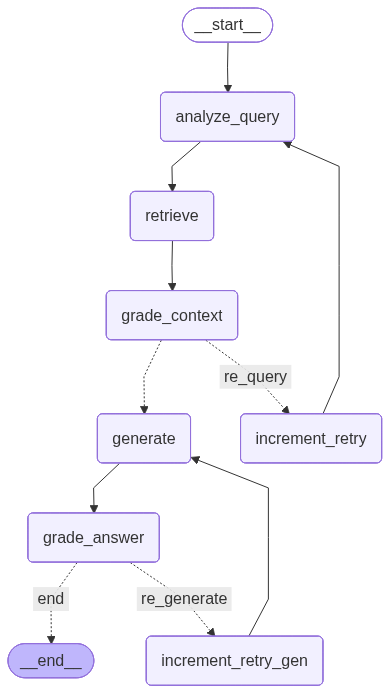

In [15]:
# ==============================================================================
# AGENTIC RAG: Visualizar el grafo
# ==============================================================================

try:
    from IPython.display import Image, display

    img_bytes = agentic_app.get_graph().draw_mermaid_png()
    display(Image(img_bytes))
except Exception:
    # Fallback: print Mermaid text
    print("Diagrama Mermaid (renderizar en mermaid.live):")
    print(agentic_app.get_graph().draw_mermaid())

In [16]:
# ==============================================================================
# AGENTIC RAG: Wrapper + test
# ==============================================================================


def rag_agentic(query: str) -> dict:
    """Ejecuta el pipeline Agentic RAG con trace completo."""
    t0 = time.perf_counter()
    initial_state: AgenticRAGState = {
        "query": query,
        "refined_query": "",
        "docs": [],
        "context_relevant": False,
        "context_reasoning": "",
        "answer": "",
        "answer_grounded": False,
        "answer_reasoning": "",
        "retry_count": 0,
        "steps_trace": [],
        "total_tokens": 0,
    }
    result = agentic_app.invoke(initial_state)
    latency_s = time.perf_counter() - t0

    # Estimar tokens totales (input + output)
    total_tokens = result.get("total_tokens", 0)
    cost = total_tokens * 0.15 / 1_000_000  # Approx (mayoria input)

    return {
        "query": query,
        "answer": result["answer"],
        "retrieved": result["docs"],
        "steps_trace": result["steps_trace"],
        "retry_count": result["retry_count"],
        "total_tokens": total_tokens,
        "cost_usd": cost,
        "latency_s": latency_s,
    }


# --- Test ---
agentic_result = rag_agentic(test_query)

print("=" * 60)
print("AGENTIC RAG: RESULTADO")
print("=" * 60)
print(f"Query:       {agentic_result['query']}")
print(f"Answer:      {agentic_result['answer'][:200]}...")
print(f"Retries:     {agentic_result['retry_count']}")
print(f"Tokens:      {agentic_result['total_tokens']:,}")
print(f"Costo:       ${agentic_result['cost_usd']:.6f}")
print(f"Latencia:    {agentic_result['latency_s']:.1f}s")
print("=" * 60)
print("\nTrace de pasos:")
for step in agentic_result["steps_trace"]:
    print(f"  -> {step}")

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ContextGrade(relevant=Tru...iensa de estos libros.'), input_type=ContextGrade])
  return self.__pydantic_serializer__.to_python(


AGENTIC RAG: RESULTADO
Query:       Que piensa Cervantes sobre los libros de caballeria?
Answer:      Cervantes critica los libros de caballerías, considerándolos responsables de arruinar el entendimiento de las personas, como se refleja en la decisión de deshacerse de ellos y en la opinión del protag...
Retries:     0
Tokens:      1,219
Costo:       $0.000183
Latencia:    6.1s

Trace de pasos:
  -> analyze_query: using original -> 'Que piensa Cervantes sobre los libros de caballeria?'
  -> retrieve: got 3 docs for 'Que piensa Cervantes sobre los libros de caballeria?'
  -> grade_context: relevant=True (El contexto recuperado menciona explícitamente la opinión de Cervantes sobre los libros de caballería, indicando que los considera perjudiciales para el entendimiento y que desea deshacerse de ellos. Esto es directamente relevante para la pregunta sobre lo que Cervantes piensa de estos libros.)
  -> generate: produced answer
  -> grade_answer: grounded=True (La respuesta resume adecuada

/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=AnswerGrade(grounded=True...mentos proporcionados.'), input_type=AnswerGrade])
  return self.__pydantic_serializer__.to_python(


---

## Seccion 6: Evaluacion Comparativa

Ahora comparamos los 3 enfoques sistematicamente con un conjunto de **6 preguntas** que abarcan capitulos I-VIII del Quijote.

Cada pregunta tiene **keywords de ground truth** -- medimos cuantas keywords aparecen en la respuesta (**precision proxy = keyword recall**).

> **Nota**: Keyword recall NO es una metrica robusta para produccion (ver analisis critico al final). Pero es suficiente para ilustrar las diferencias entre enfoques.

In [17]:
# ==============================================================================
# EVALUACION: Definir eval_set con ground truth keywords
# ==============================================================================

eval_set = [
    {
        "query": "Que comia el hidalgo y como era su dieta semanal?",
        "keywords": ["olla", "vaca", "carnero", "salpicon", "lentejas", "palomino", "duelos", "quebrantos"],
    },
    {
        "query": "Como se llama el caballo del protagonista y como era?",
        "keywords": ["rocinante", "rocin", "flaco"],
    },
    {
        "query": "Quien es Dulcinea y que relacion tiene con Don Quijote?",
        "keywords": ["dulcinea", "toboso", "aldonza", "lorenzo"],
    },
    {
        "query": "Que ocurre en el episodio de los molinos de viento?",
        "keywords": ["molinos", "viento", "gigantes", "lanza", "aspas"],
    },
    {
        "query": "Que hicieron el cura y el barbero con los libros de Don Quijote?",
        "keywords": ["libros", "quemaron", "fuego", "cura", "barbero", "escrutinio"],
    },
    {
        "query": "Como se incorpora Sancho Panza a las aventuras?",
        "keywords": ["sancho", "panza", "escudero", "labrador", "insula"],
    },
]


def precision_proxy(answer: str, keywords: list[str]) -> float:
    """Keyword recall: fraccion de keywords esperadas presentes en la respuesta."""
    answer_lower = answer.lower()
    hits = sum(1 for k in keywords if k in answer_lower)
    return hits / len(keywords) if keywords else 0.0


print("=" * 60)
print("EVAL SET DEFINIDO")
print("=" * 60)
for i, ex in enumerate(eval_set):
    print(f"  Q{i+1}: {ex['query']}")
    print(f"       Keywords: {ex['keywords']}")
print(f"\nTotal: {len(eval_set)} preguntas")
print("=" * 60)

EVAL SET DEFINIDO
  Q1: Que comia el hidalgo y como era su dieta semanal?
       Keywords: ['olla', 'vaca', 'carnero', 'salpicon', 'lentejas', 'palomino', 'duelos', 'quebrantos']
  Q2: Como se llama el caballo del protagonista y como era?
       Keywords: ['rocinante', 'rocin', 'flaco']
  Q3: Quien es Dulcinea y que relacion tiene con Don Quijote?
       Keywords: ['dulcinea', 'toboso', 'aldonza', 'lorenzo']
  Q4: Que ocurre en el episodio de los molinos de viento?
       Keywords: ['molinos', 'viento', 'gigantes', 'lanza', 'aspas']
  Q5: Que hicieron el cura y el barbero con los libros de Don Quijote?
       Keywords: ['libros', 'quemaron', 'fuego', 'cura', 'barbero', 'escrutinio']
  Q6: Como se incorpora Sancho Panza a las aventuras?
       Keywords: ['sancho', 'panza', 'escudero', 'labrador', 'insula']

Total: 6 preguntas


In [18]:
# ==============================================================================
# EVALUACION: Ejecutar 3 enfoques en todas las queries
# ==============================================================================

print("Ejecutando evaluacion comparativa...")
print("Esto toma ~2-3 minutos (multiples LLM calls)\n")

rows = []
for i, ex in enumerate(eval_set):
    q = ex["query"]
    kw = ex["keywords"]
    print(f"  Q{i+1}/{len(eval_set)}: {q[:50]}...")

    # Context Stuffing
    cs = context_stuffing_answer(q, texto_quijote)

    # Simple RAG
    sr = rag_simple(q, k=3)

    # Agentic RAG
    ar = rag_agentic(q)

    rows.append({
        "query": q[:40] + "...",
        "cs_precision": precision_proxy(cs["answer"], kw),
        "rag_precision": precision_proxy(sr["answer"], kw),
        "agentic_precision": precision_proxy(ar["answer"], kw),
        "cs_tokens": cs["input_tokens"],
        "rag_tokens": sr["input_tokens"],
        "agentic_tokens": ar["total_tokens"],
        "cs_cost": cs["cost_usd"],
        "rag_cost": sr["cost_usd"],
        "agentic_cost": ar["cost_usd"],
        "cs_latency": cs["latency_s"],
        "rag_latency": sr["latency_s"],
        "agentic_latency": ar["latency_s"],
        "agentic_retries": ar["retry_count"],
    })

report = pd.DataFrame(rows)
print("\nEvaluacion completada!")

# --- Mostrar tabla resumen ---
print("\n" + "=" * 60)
print("TABLA RESUMEN")
print("=" * 60)

summary = pd.DataFrame({
    "Metrica": ["Precision promedio", "Tokens promedio", "Costo promedio (USD)", "Latencia promedio (s)"],
    "Context Stuffing": [
        f"{report['cs_precision'].mean():.2f}",
        f"{report['cs_tokens'].mean():,.0f}",
        f"${report['cs_cost'].mean():.6f}",
        f"{report['cs_latency'].mean():.1f}",
    ],
    "Simple RAG": [
        f"{report['rag_precision'].mean():.2f}",
        f"{report['rag_tokens'].mean():,.0f}",
        f"${report['rag_cost'].mean():.6f}",
        f"{report['rag_latency'].mean():.1f}",
    ],
    "Agentic RAG": [
        f"{report['agentic_precision'].mean():.2f}",
        f"{report['agentic_tokens'].mean():,.0f}",
        f"${report['agentic_cost'].mean():.6f}",
        f"{report['agentic_latency'].mean():.1f}",
    ],
})
print(summary.to_string(index=False))

Ejecutando evaluacion comparativa...
Esto toma ~2-3 minutos (multiples LLM calls)

  Q1/6: Que comia el hidalgo y como era su dieta semanal?...


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ContextGrade(relevant=Tru... y cómo era su dieta.'), input_type=ContextGrade])
  return self.__pydantic_serializer__.to_python(


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=AnswerGrade(grounded=True...scribe en el contexto.'), input_type=AnswerGrade])
  return self.__pydantic_serializer__.to_python(


  Q2/6: Como se llama el caballo del protagonista y como e...


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ContextGrade(relevant=Tru...levante para la query.'), input_type=ContextGrade])
  return self.__pydantic_serializer__.to_python(


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=AnswerGrade(grounded=True...ontexto proporcionado.'), input_type=AnswerGrade])
  return self.__pydantic_serializer__.to_python(


  Q3/6: Quien es Dulcinea y que relacion tiene con Don Qui...


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ContextGrade(relevant=Tru...xión con Don Quijote.'), input_type=ContextGrade])
  return self.__pydantic_serializer__.to_python(


  Q4/6: Que ocurre en el episodio de los molinos de viento...


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ContextGrade(relevant=Tru...curre en ese episodio.'), input_type=ContextGrade])
  return self.__pydantic_serializer__.to_python(


  Q5/6: Que hicieron el cura y el barbero con los libros d...


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ContextGrade(relevant=Tru...ante para la pregunta.'), input_type=ContextGrade])
  return self.__pydantic_serializer__.to_python(


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=AnswerGrade(grounded=True...parece en el contexto."), input_type=AnswerGrade])
  return self.__pydantic_serializer__.to_python(


  Q6/6: Como se incorpora Sancho Panza a las aventuras?...


/Users/carlosdaniel/Documents/Projects/labor_projects/Henry/2026/01-introduction_ai_engineering/ai_engineering_henry/02-vector_data_bases/.venv/lib/python3.11/site-packages/pydantic/main.py:464: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `none` - serialized value may not be as expected [field_name='parsed', input_value=ContextGrade(relevant=Tru...Panza a las aventuras.'), input_type=ContextGrade])
  return self.__pydantic_serializer__.to_python(



Evaluacion completada!

TABLA RESUMEN
              Metrica Context Stuffing Simple RAG Agentic RAG
   Precision promedio             0.86       0.66        0.66
      Tokens promedio           27,732        413       1,350
 Costo promedio (USD)        $0.004221  $0.000105   $0.000203
Latencia promedio (s)              7.8        2.6         6.0


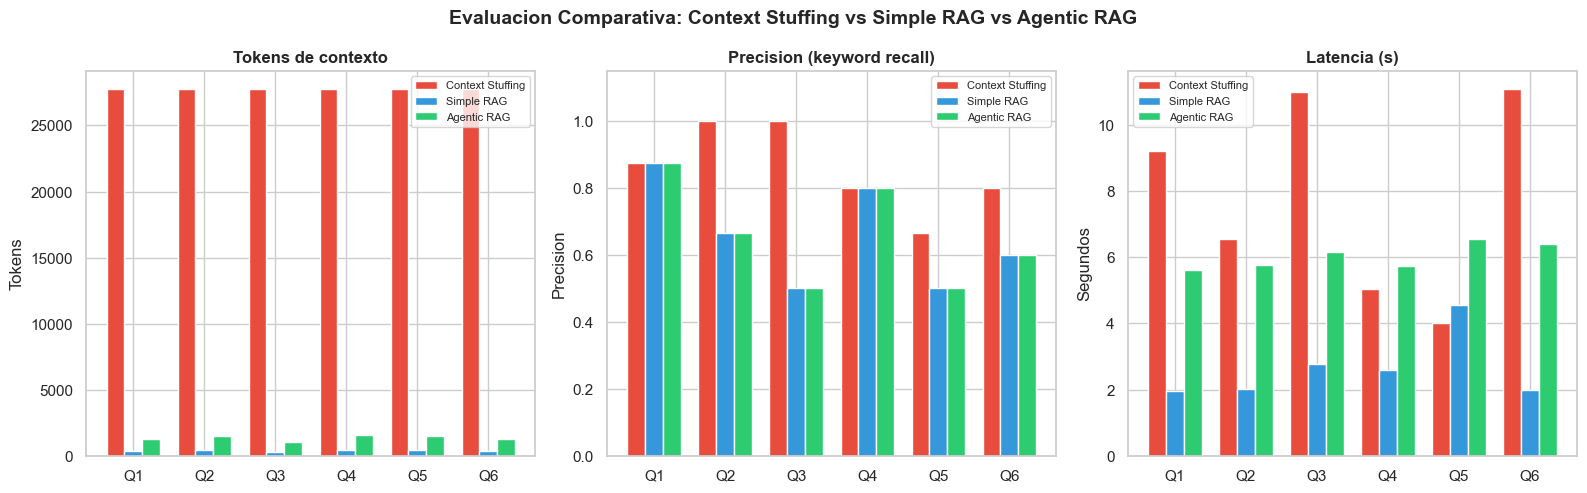

In [19]:
# ==============================================================================
# VISUALIZACION: Bar chart 3-panel de la evaluacion
# ==============================================================================

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

x = np.arange(len(report))
width = 0.25
labels = [f"Q{i+1}" for i in range(len(report))]

# --- Panel 1: Tokens de contexto ---
axes[0].bar(x - width, report["cs_tokens"], width, label="Context Stuffing", color="#e74c3c")
axes[0].bar(x, report["rag_tokens"], width, label="Simple RAG", color="#3498db")
axes[0].bar(x + width, report["agentic_tokens"], width, label="Agentic RAG", color="#2ecc71")
axes[0].set_title("Tokens de contexto", fontsize=12, fontweight="bold")
axes[0].set_xticks(x)
axes[0].set_xticklabels(labels)
axes[0].set_ylabel("Tokens")
axes[0].legend(fontsize=8)

# --- Panel 2: Precision (keyword recall) ---
axes[1].bar(x - width, report["cs_precision"], width, label="Context Stuffing", color="#e74c3c")
axes[1].bar(x, report["rag_precision"], width, label="Simple RAG", color="#3498db")
axes[1].bar(x + width, report["agentic_precision"], width, label="Agentic RAG", color="#2ecc71")
axes[1].set_title("Precision (keyword recall)", fontsize=12, fontweight="bold")
axes[1].set_xticks(x)
axes[1].set_xticklabels(labels)
axes[1].set_ylim(0, 1.15)
axes[1].set_ylabel("Precision")
axes[1].legend(fontsize=8)

# --- Panel 3: Latencia ---
axes[2].bar(x - width, report["cs_latency"], width, label="Context Stuffing", color="#e74c3c")
axes[2].bar(x, report["rag_latency"], width, label="Simple RAG", color="#3498db")
axes[2].bar(x + width, report["agentic_latency"], width, label="Agentic RAG", color="#2ecc71")
axes[2].set_title("Latencia (s)", fontsize=12, fontweight="bold")
axes[2].set_xticks(x)
axes[2].set_xticklabels(labels)
axes[2].set_ylabel("Segundos")
axes[2].legend(fontsize=8)

fig.suptitle(
    "Evaluacion Comparativa: Context Stuffing vs Simple RAG vs Agentic RAG",
    fontsize=14, fontweight="bold",
)
plt.tight_layout()
plt.show()

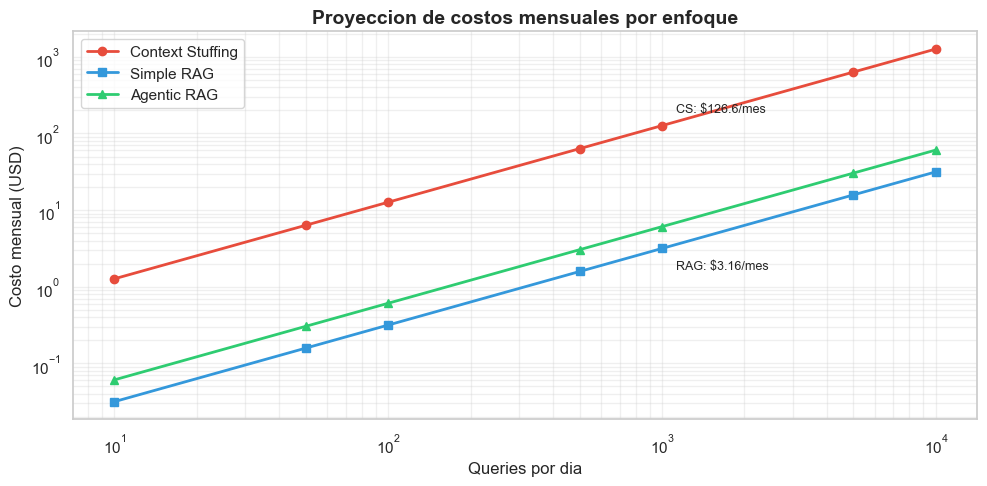

PROYECCION A 1,000 QUERIES/DIA
  Context Stuffing: $126.62/mes
  Simple RAG:       $3.16/mes
  Agentic RAG:      $6.08/mes
  Ahorro RAG vs CS: 40x


In [20]:
# ==============================================================================
# PROYECCION DE COSTOS: queries/dia vs costo mensual
# ==============================================================================

queries_per_day = [10, 50, 100, 500, 1000, 5000, 10000]

avg_cs_cost = report["cs_cost"].mean()
avg_rag_cost = report["rag_cost"].mean()
avg_agentic_cost = report["agentic_cost"].mean()

cs_monthly = [q * avg_cs_cost * 30 for q in queries_per_day]
rag_monthly = [q * avg_rag_cost * 30 for q in queries_per_day]
agentic_monthly = [q * avg_agentic_cost * 30 for q in queries_per_day]

fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(queries_per_day, cs_monthly, "o-", label="Context Stuffing", color="#e74c3c", linewidth=2)
ax.plot(queries_per_day, rag_monthly, "s-", label="Simple RAG", color="#3498db", linewidth=2)
ax.plot(queries_per_day, agentic_monthly, "^-", label="Agentic RAG", color="#2ecc71", linewidth=2)

ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel("Queries por dia", fontsize=12)
ax.set_ylabel("Costo mensual (USD)", fontsize=12)
ax.set_title("Proyeccion de costos mensuales por enfoque", fontsize=14, fontweight="bold")
ax.legend(fontsize=11)
ax.grid(True, which="both", alpha=0.3)

# Anotar el punto de 1000 queries/dia
for i, q in enumerate(queries_per_day):
    if q == 1000:
        ax.annotate(
            f"CS: ${cs_monthly[i]:.1f}/mes",
            (q, cs_monthly[i]),
            textcoords="offset points", xytext=(10, 10), fontsize=9,
        )
        ax.annotate(
            f"RAG: ${rag_monthly[i]:.2f}/mes",
            (q, rag_monthly[i]),
            textcoords="offset points", xytext=(10, -15), fontsize=9,
        )

plt.tight_layout()
plt.show()

print("=" * 60)
print("PROYECCION A 1,000 QUERIES/DIA")
print("=" * 60)
idx_1k = queries_per_day.index(1000)
print(f"  Context Stuffing: ${cs_monthly[idx_1k]:.2f}/mes")
print(f"  Simple RAG:       ${rag_monthly[idx_1k]:.2f}/mes")
print(f"  Agentic RAG:      ${agentic_monthly[idx_1k]:.2f}/mes")
print(f"  Ahorro RAG vs CS: {cs_monthly[idx_1k] / rag_monthly[idx_1k]:.0f}x")
print("=" * 60)

---

## Seccion 7: Analisis Critico

### Fortalezas de este notebook

- **Texto real**: ~15K palabras del Quijote, no un parrafo de juguete.
- **ChromaDB real**: Base de datos vectorial con embeddings de OpenAI, no solo TF-IDF.
- **Metricas cuantitativas**: Tokens, costo, latencia y precision medidos en cada enfoque.
- **Agentic con reasoning loops**: Grading de contexto y respuesta, no solo heuristicas.

### Limitaciones

- **Keyword recall no es robusta**: Una respuesta correcta puede no usar las keywords exactas. En produccion usar RAGAS, ARES, o evaluacion humana.
- **Corpus unico**: Solo Don Quijote. Generalizar requiere evaluar con multiples corpus.
- **ChromaDB in-memory**: No persiste entre ejecuciones. Produccion requiere persistencia.
- **Self-grading circular**: El mismo LLM que genera la respuesta evalua su calidad. Sesgo inherente.

### Cuando usar cada enfoque

| Enfoque | Mejor para | Evitar cuando |
|---------|-----------|---------------|
| **Context Stuffing** | Textos cortos (< 4K tokens), prototipado rapido | Corpus grandes, costos importan |
| **Simple RAG** | Corpus medianos, latencia predecible, produccion | Se necesita autocorreccion |
| **Agentic RAG** | Queries complejas, calidad critica, autocorreccion | Latencia critica, presupuesto limitado |

### Roadmap a produccion

1. **Vector DB escalable**: FAISS para batch, Pinecone/Qdrant para produccion cloud.
2. **Golden dataset**: Evaluacion con scorecards humanas, no solo keyword recall.
3. **Observabilidad**: LangSmith, Phoenix, o Weights & Biases para trazas y costos.
4. **Guardrails**: Validacion de fuentes, deteccion de PII, limites de costo por query.
5. **Chunking strategy**: Experimentar con semantic chunking, parent-child, o agentic chunking.

### Referencias

- Chip Huyen (2024). *AI Engineering: Building Applications with Foundation Models*. O'Reilly.
- Asai, A., Wu, Z., Wang, Y., Sil, A., & Hajishirzi, H. (2023). *Self-RAG: Learning to Retrieve, Generate, and Critique through Self-Reflection*. arXiv:2310.11511.
- Liu, N. F., Lin, K., Hewitt, J., Paranjape, A., Bevilacqua, M., Petroni, F., & Liang, P. (2023). *Lost in the Middle: How Language Models Use Long Contexts*. arXiv:2307.03172.

---

## Checklist de Consolidacion

Antes de avanzar, asegurate de poder responder estas preguntas:

- [ ] **1.** Por que context stuffing no escala? Calcula el costo mensual de pasar 20K tokens por query a 1000 queries/dia con gpt-4o-mini.

- [ ] **2.** Explica la formula TF-IDF con tus palabras. Por que "de" tiene score bajo y "Rocinante" tiene score alto?

- [ ] **3.** Cual es la diferencia fundamental entre TF-IDF (sparse) y embeddings de OpenAI (dense)? Da un ejemplo donde TF-IDF falla y embeddings aciertan.

- [ ] **4.** Que almacena ChromaDB para cada documento? Explica el flujo completo de `collection.add()` y `collection.query()`.

- [ ] **5.** Dibuja el diagrama del Agentic RAG. En que casos se dispara el loop de re-query? Y el de re-generate?

- [ ] **6.** Keyword recall como metrica tiene un sesgo importante. Cual es? Que metrica usarias en produccion y por que?

---

*Fin del Notebook: De Texto Completo a Agentic RAG*